In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
import numpy as np

In [2]:
 class Generator(nn.Module):
    def __init__(self, latent_dim):
         super(Generator, self).__init__()
         
         self.fc1 = nn.Linear(100, latent_dim)
         self.fc2 = nn.Linear(latent_dim, 28*28)
            

         self.train_data = {
             'epoch' : [],
             'loss'  : []
         }


         self.val_data = {
             'epoch' : [],
             'loss'  : []
         }


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x.view(-1, 28, 28)

    
    

In [3]:
class Discriminator(nn.Module):
    def __init__(self, laten_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, laten_dim)
        self.fc2 = nn.Linear(laten_dim, 1)

        self.train_data = {
            'epoch' : [],
            'loss'  : []
        }


        self.val_data = {
            'epoch' : [],
            'loss'  : []
        }


    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)


        return x

In [4]:
generator = Generator(128).cuda()
discriminator = Discriminator(128).cuda()

In [5]:
disc_opt = torch.optim.Adam(discriminator.parameters(), 0.0001)

gen_opt = torch.optim.Adam(generator.parameters(), 0.0001)


In [6]:
total_epochs = 0

In [7]:
from torchvision.datasets import MNIST
import torchvision

train_data = MNIST("data/", train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)




In [8]:
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

writer = SummaryWriter()


In [9]:
def train(epochs):
    global total_epochs
    generator.train()
    discriminator.train()
    for i in range(epochs):
        total_epochs += 1
        d_train_loss_sum  = 0
        g_train_loss_sum  = 0
        
        for batchidx, (real_train, label) in enumerate(trainloader):
            generator.zero_grad()
            discriminator.zero_grad()
            real_train = real_train.cuda()
            gen_input = torch.cuda.FloatTensor(30, 100).normal_()
            fake_train = generator(gen_input)
            disc_fake_out = discriminator(fake_train)
            disc_real_out = discriminator(real_train)
            fake_disc_loss = F.binary_cross_entropy(disc_fake_out, torch.ones_like(disc_fake_out))
            real_disc_loss = F.binary_cross_entropy(disc_real_out, torch.zeros_like(disc_real_out))
            
            d_loss = fake_disc_loss + real_disc_loss
            d_train_loss_sum += d_loss.item()
            
            d_loss.backward()
            disc_opt.step()

            input_gen = torch.cuda.FloatTensor(30, 100).normal_()
            fake_gen = generator(input_gen)
            disc_fake_out = discriminator(fake_gen)
            g_loss = F.binary_cross_entropy(disc_fake_out, torch.zeros_like(disc_fake_out))
            g_loss.backward()
            gen_opt.step()

            g_train_loss_sum += g_loss.item()
        
        disc_loss_epoch = d_train_loss_sum / (batchidx+1)
        gen_loss_epoch = g_train_loss_sum / (batchidx+1)

        discriminator.train_data['epoch'] = total_epochs
        discriminator.train_data['loss'] = disc_loss_epoch
        generator.train_data['epoch'] = total_epochs
        generator.train_data['loss'] = gen_loss_epoch

        print("Epoch {}-->Generator Loss: {} Discriminator Loss: {}".format(total_epochs, gen_loss_epoch, disc_loss_epoch))
        gen_input = torch.cuda.FloatTensor(10, 100).normal_()
        fake_images = generator(gen_input)

        
        gen_input = torch.cuda.FloatTensor(10, 100).normal_()
        gen_images = generator(gen_input)
        gen_images = gen_images.cpu().data.numpy()
        fig=plt.figure(figsize=(10, 10))
        columns = 3
        rows = 3
        for t in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, t)
            #plt.imshow(np.reshape(gen_images[i-1], newshape=(img_size, img_size)), cmap="gray")
            plt.imshow(np.reshape(gen_images[t-1], newshape=(28, 28)), cmap="gray")
        plt.show()

        writer.add_scalars("Train Losses", {"disc": disc_loss_epoch, "gen": gen_loss_epoch}, total_epochs)
        writer.add_image()

    writer.close()






Epoch 12-->Generator Loss: 2.7562229377031326 Discriminator Loss: 0.24753538828343152


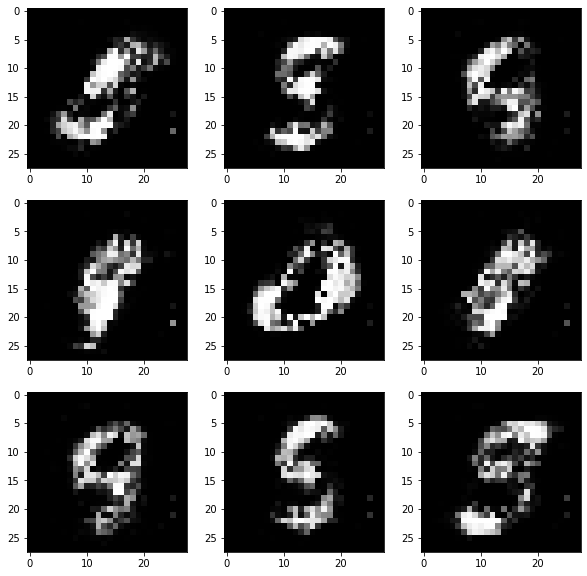

Epoch 13-->Generator Loss: 2.896842261552811 Discriminator Loss: 0.22266031049812834


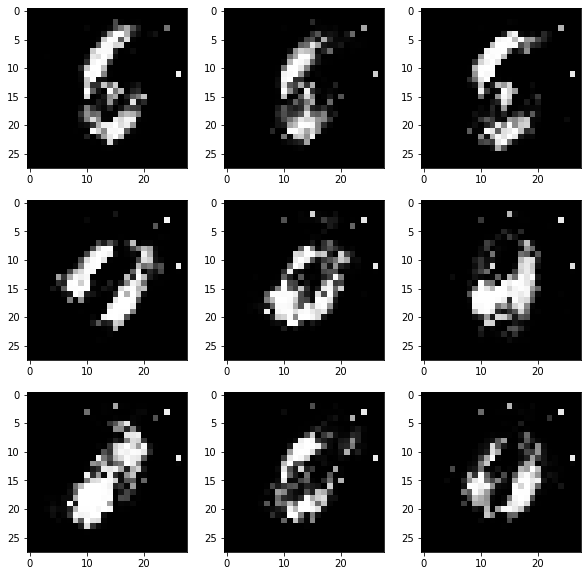

Epoch 14-->Generator Loss: 3.1192473914225896 Discriminator Loss: 0.23140213249251246


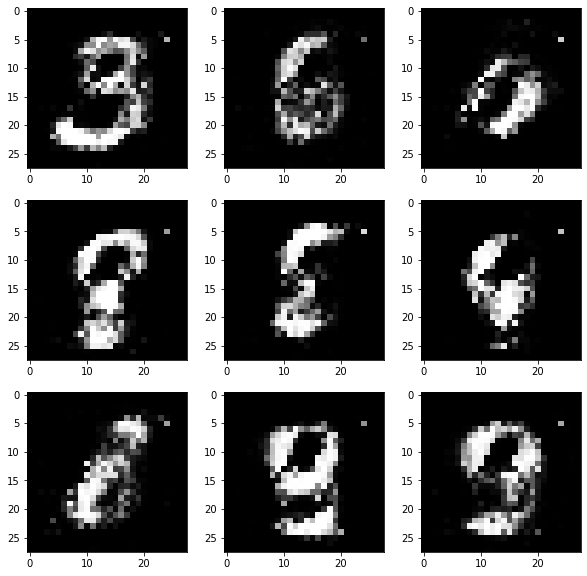

Epoch 15-->Generator Loss: 2.948874462445577 Discriminator Loss: 0.2697044329158962


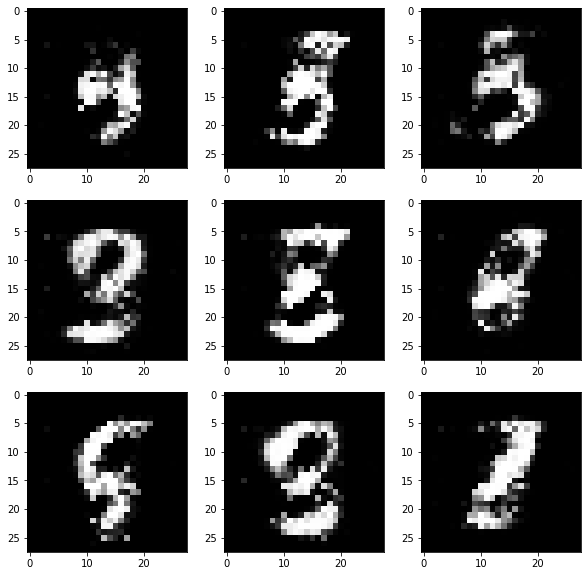

Epoch 16-->Generator Loss: 2.9153072581688564 Discriminator Loss: 0.2939948827959597


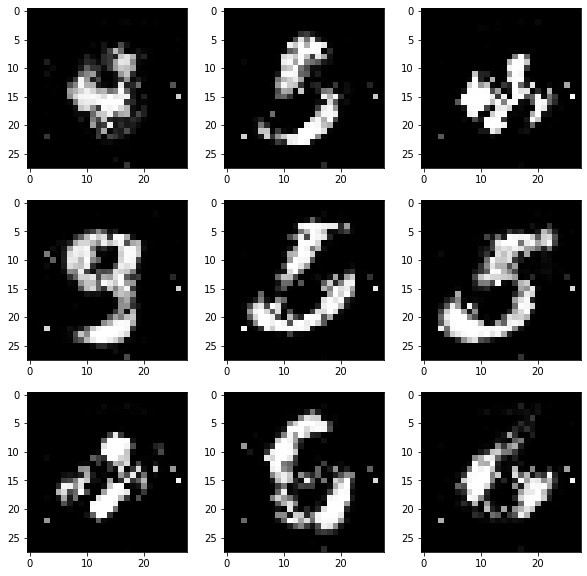

Epoch 17-->Generator Loss: 2.7858007212479907 Discriminator Loss: 0.32281688089172045


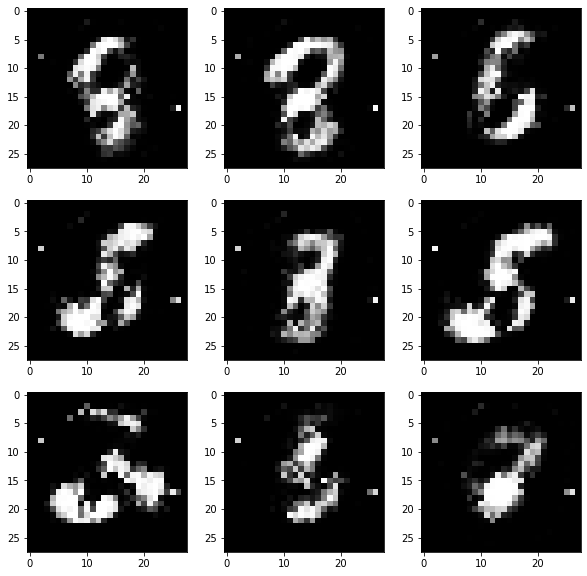

Epoch 18-->Generator Loss: 2.8061101669073105 Discriminator Loss: 0.3091351806869109


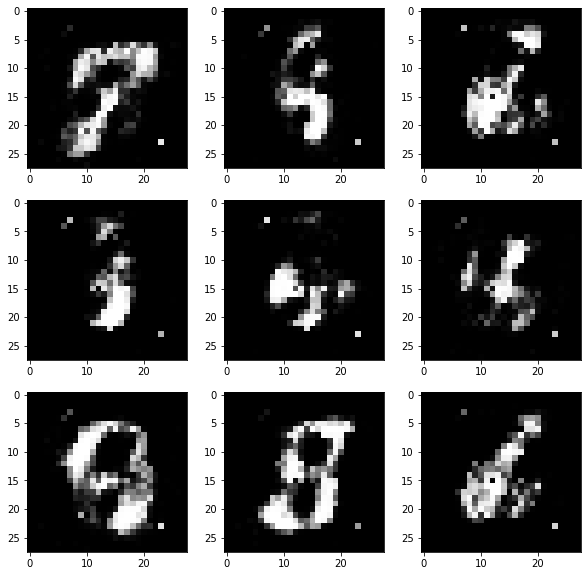

Epoch 19-->Generator Loss: 2.7946713134646415 Discriminator Loss: 0.3198819770105183


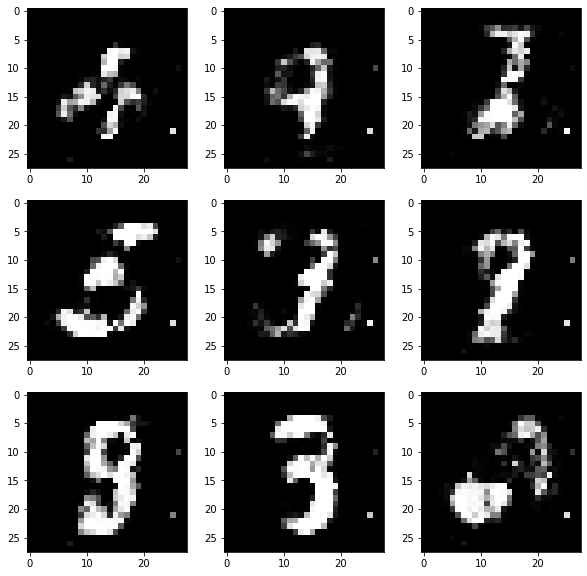

Epoch 20-->Generator Loss: 2.736038654446602 Discriminator Loss: 0.31566068015992643


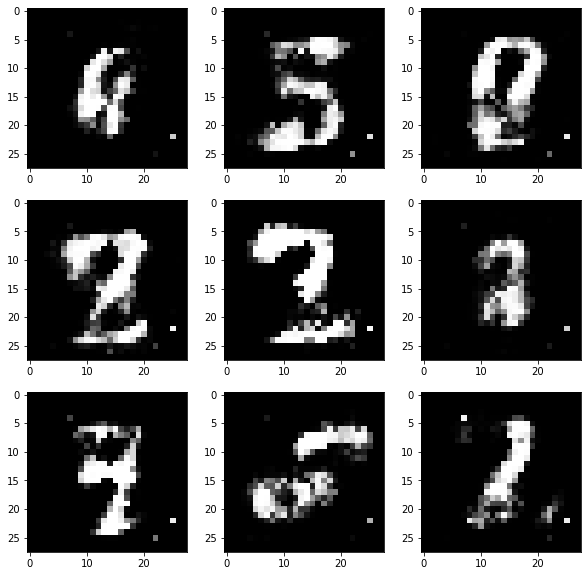

Epoch 21-->Generator Loss: 2.8848377643028895 Discriminator Loss: 0.29237833925212425


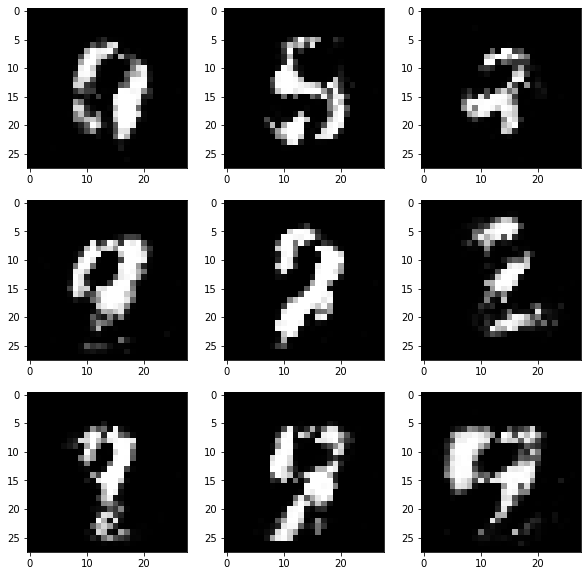

Epoch 22-->Generator Loss: 2.922738411227862 Discriminator Loss: 0.3031975849842032


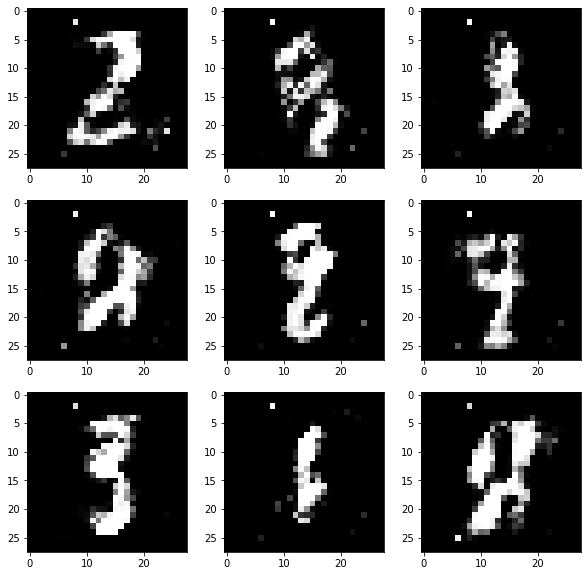

Epoch 23-->Generator Loss: 2.9558154634634652 Discriminator Loss: 0.2835027464168767


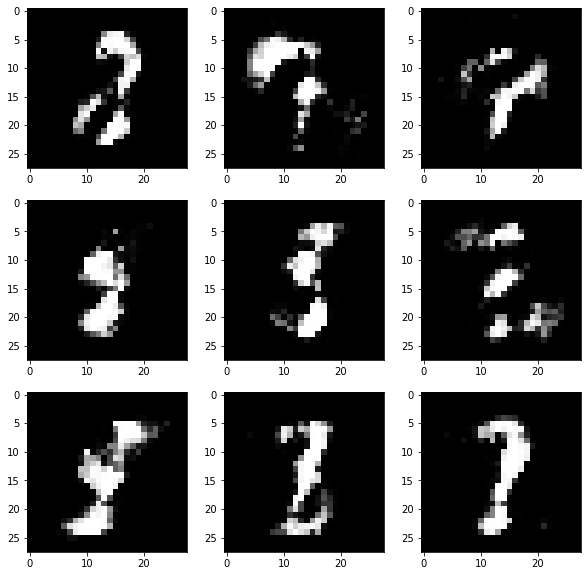

Epoch 24-->Generator Loss: 2.811088511943817 Discriminator Loss: 0.3142695791895191


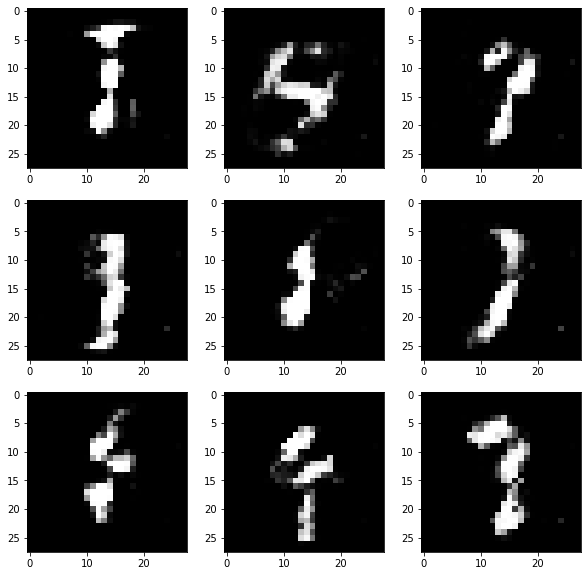

Epoch 25-->Generator Loss: 2.7478977712988852 Discriminator Loss: 0.3496528029193481


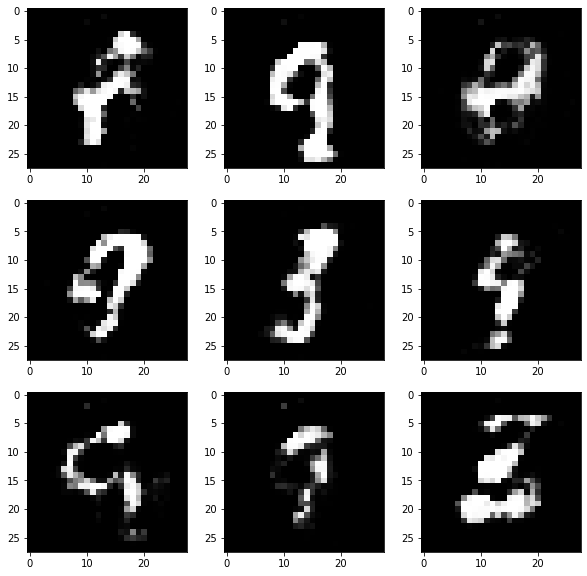

Epoch 26-->Generator Loss: 2.7123134726285936 Discriminator Loss: 0.3635072610527277


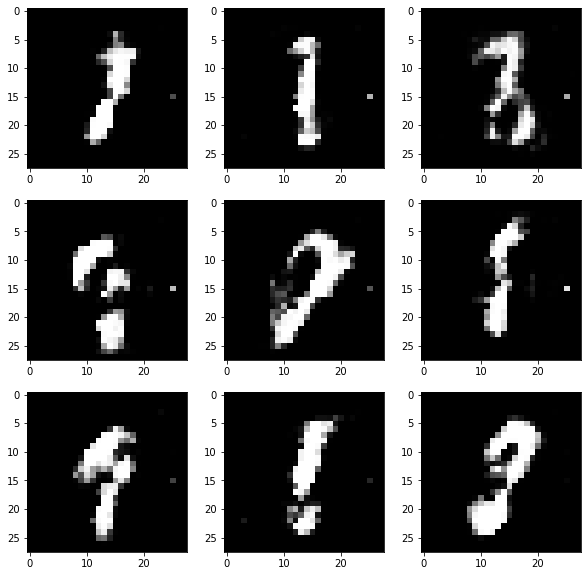

Epoch 27-->Generator Loss: 2.7889822855591775 Discriminator Loss: 0.35919910269478955


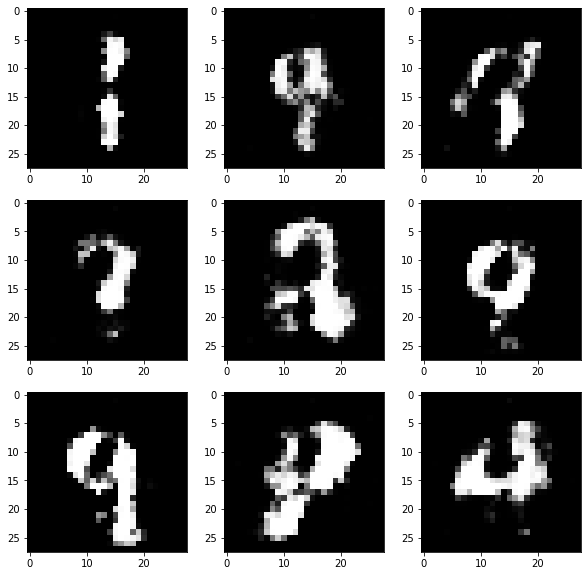

Epoch 28-->Generator Loss: 2.677545574307442 Discriminator Loss: 0.41125989163915316


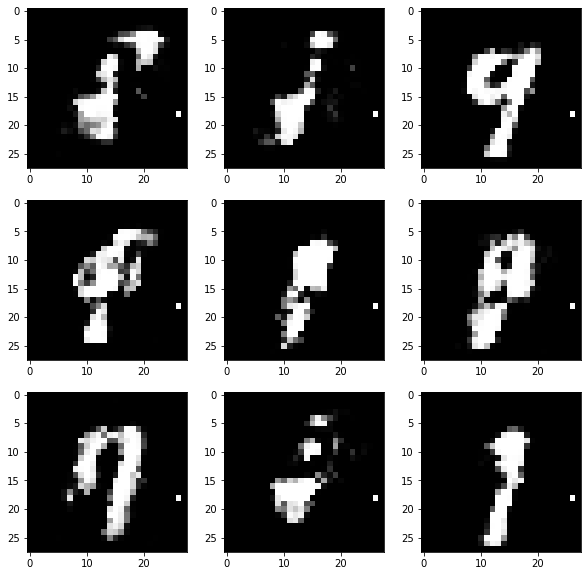

Epoch 29-->Generator Loss: 2.839917017817497 Discriminator Loss: 0.337302833336095


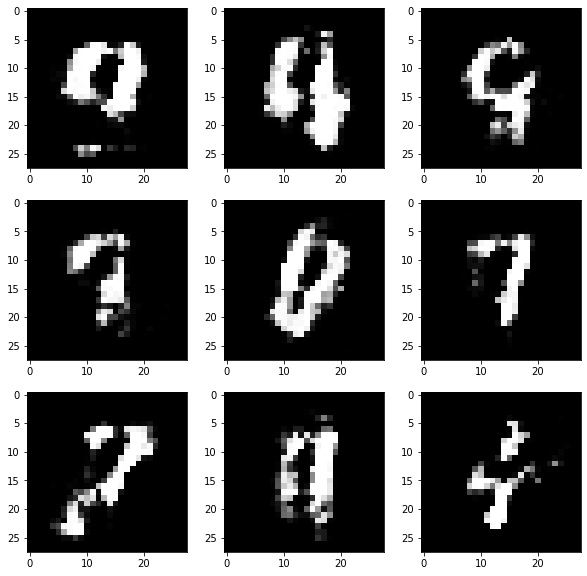

Epoch 30-->Generator Loss: 2.801554510295391 Discriminator Loss: 0.3440523217742642


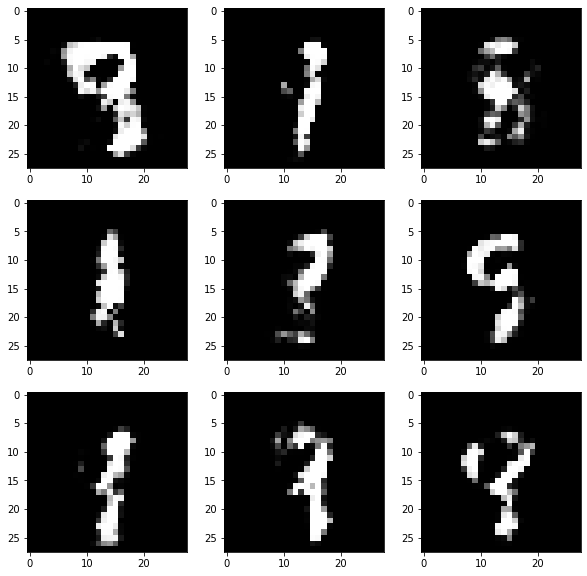

Epoch 31-->Generator Loss: 2.906478299101194 Discriminator Loss: 0.3187994751582543


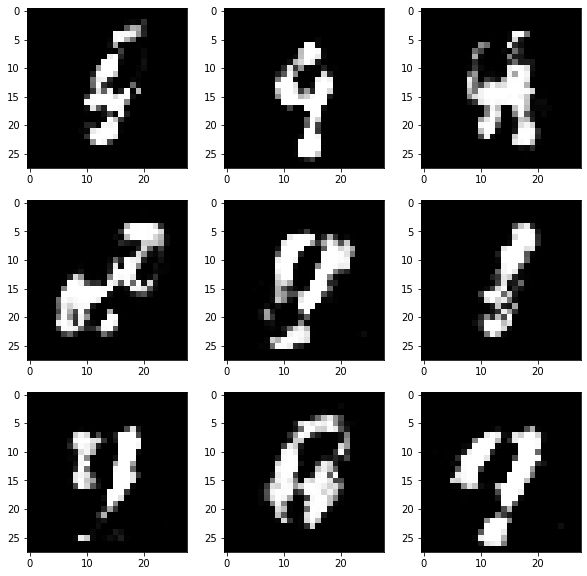

Epoch 32-->Generator Loss: 2.868169401685397 Discriminator Loss: 0.3618786973506212


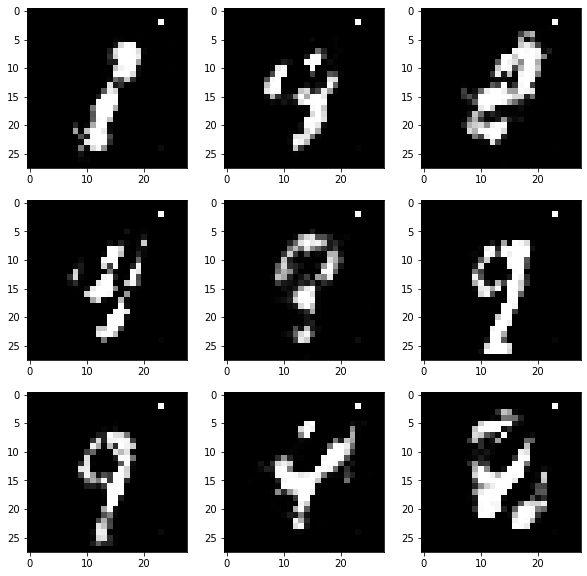

Epoch 33-->Generator Loss: 3.163131751616796 Discriminator Loss: 0.2572560281120241


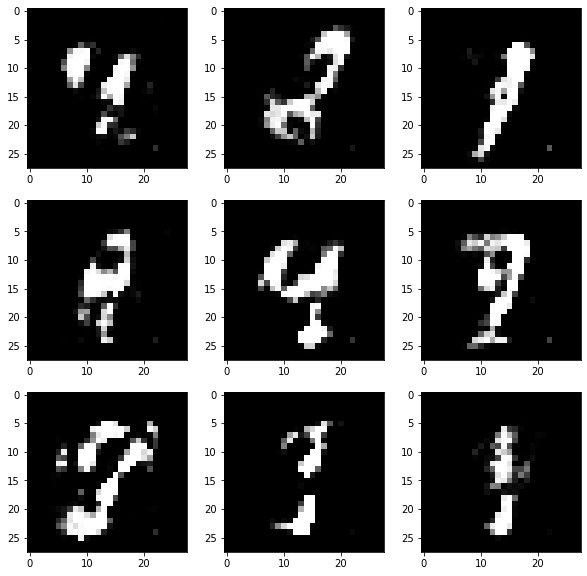

Epoch 34-->Generator Loss: 3.025311927994092 Discriminator Loss: 0.3079060457088053


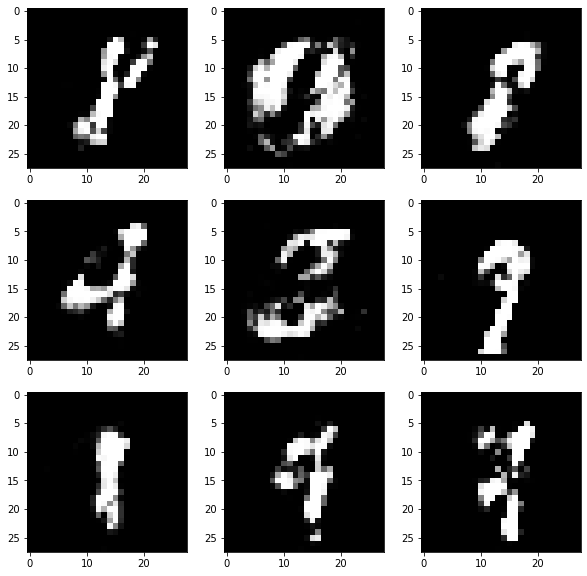

Epoch 35-->Generator Loss: 3.029357533256213 Discriminator Loss: 0.31160850229362647


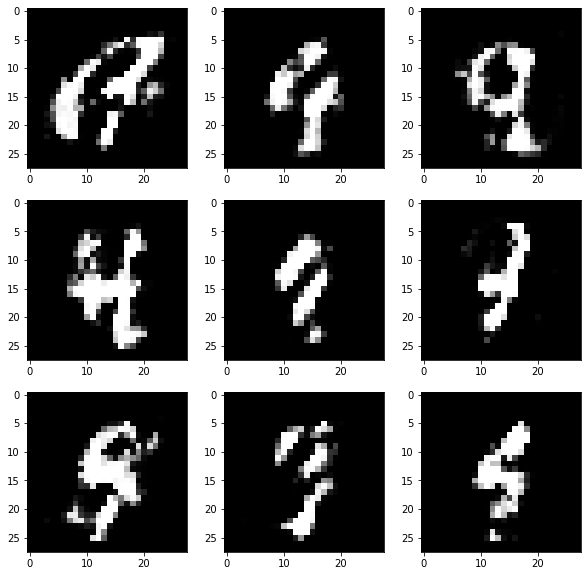

Epoch 36-->Generator Loss: 3.030749635100365 Discriminator Loss: 0.31419994454210004


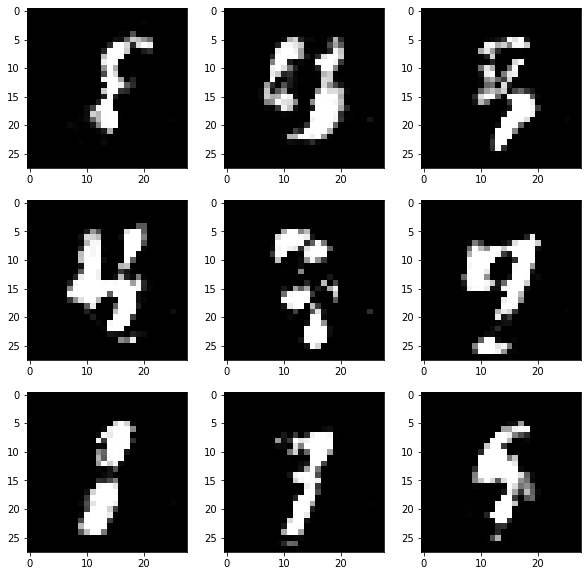

Epoch 37-->Generator Loss: 2.9967079375187557 Discriminator Loss: 0.310896652340889


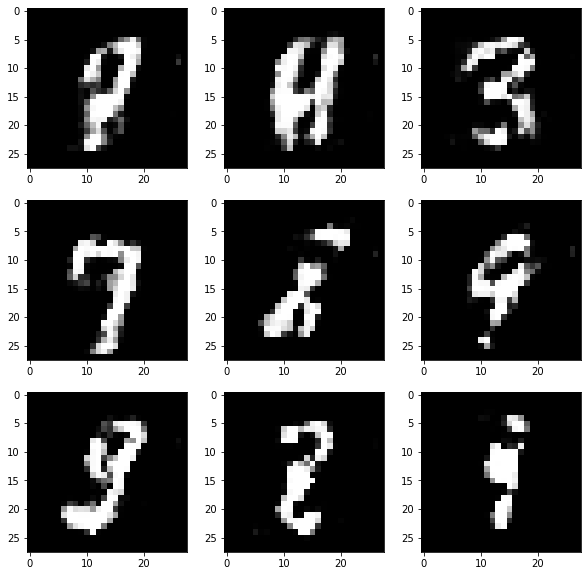

Epoch 38-->Generator Loss: 3.019257768591245 Discriminator Loss: 0.31275777354215584


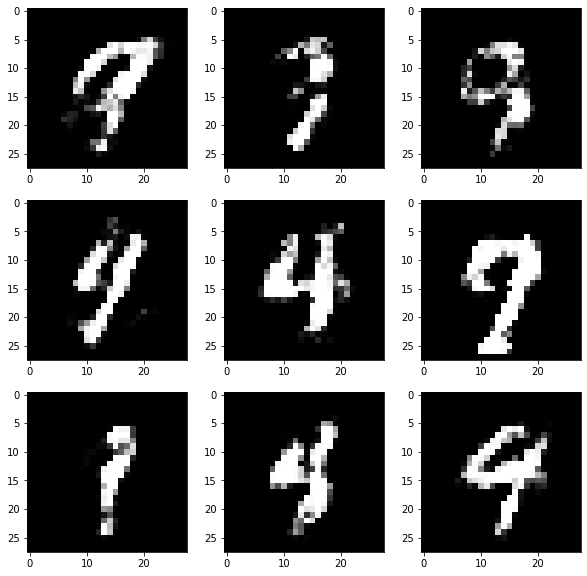

Epoch 39-->Generator Loss: 2.982360774477323 Discriminator Loss: 0.3230422640219331


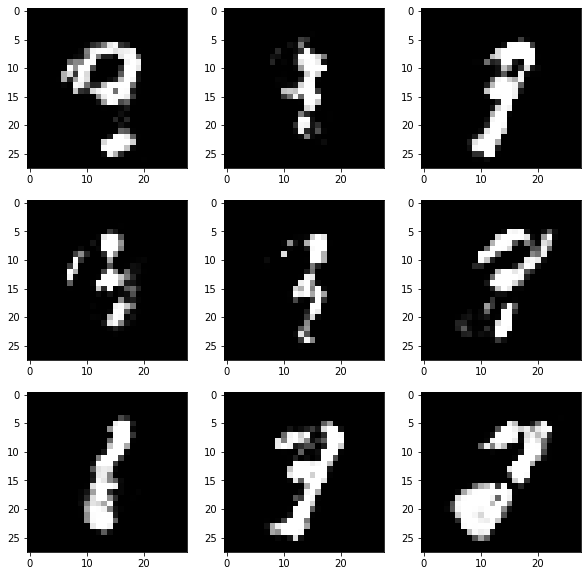

Epoch 40-->Generator Loss: 2.955944134891033 Discriminator Loss: 0.32661726403981445


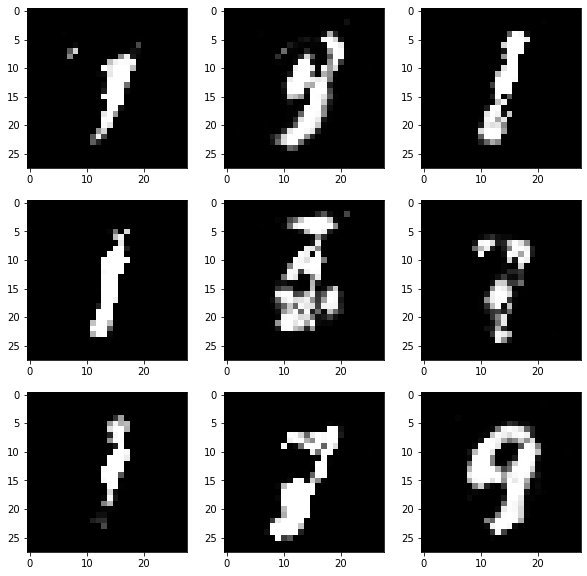

Epoch 41-->Generator Loss: 2.9808728579680124 Discriminator Loss: 0.3243429357931018


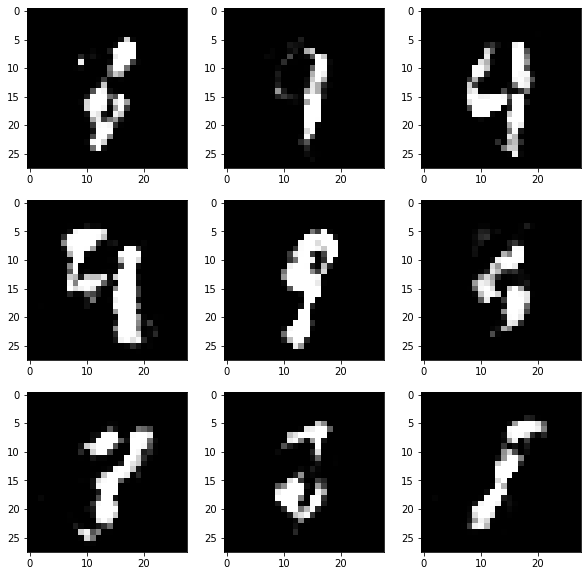

Epoch 42-->Generator Loss: 2.9919384264945985 Discriminator Loss: 0.32393034563710293


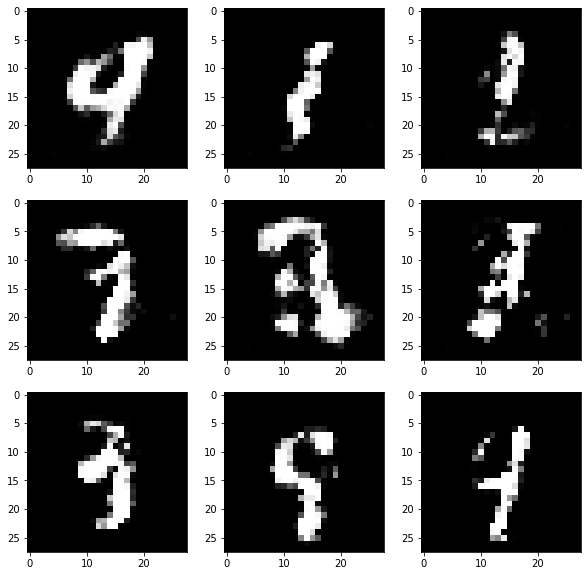

Epoch 43-->Generator Loss: 3.0566569234927496 Discriminator Loss: 0.32426052492111923


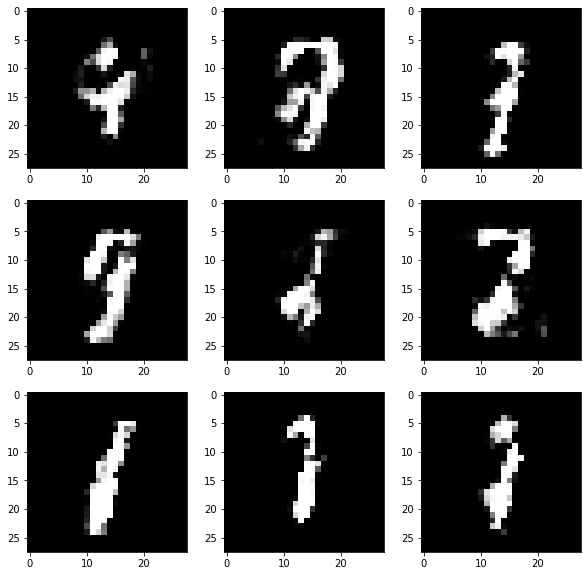

Epoch 44-->Generator Loss: 3.0460388030608496 Discriminator Loss: 0.3392362983400623


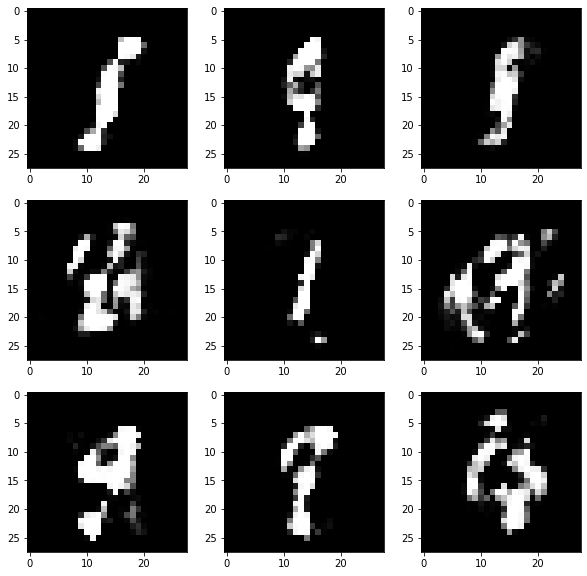

Epoch 45-->Generator Loss: 3.0125715482234954 Discriminator Loss: 0.356503882240504


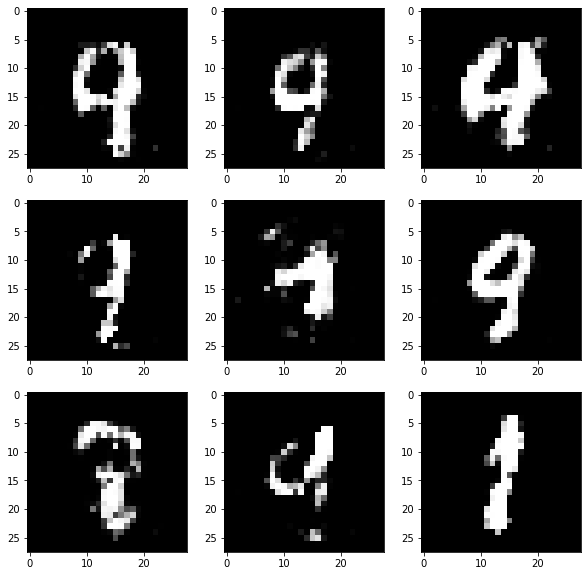

Epoch 46-->Generator Loss: 2.892055931389332 Discriminator Loss: 0.3785138332471252


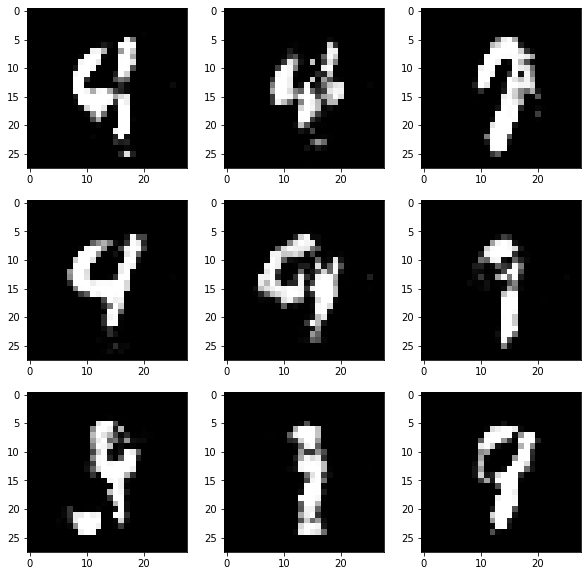

Epoch 47-->Generator Loss: 2.8196461258331933 Discriminator Loss: 0.39065232044706744


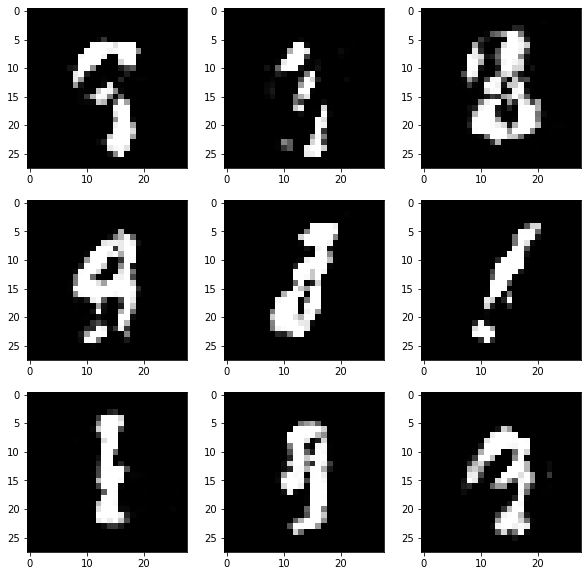

Epoch 48-->Generator Loss: 2.800916213194529 Discriminator Loss: 0.3826302232158681


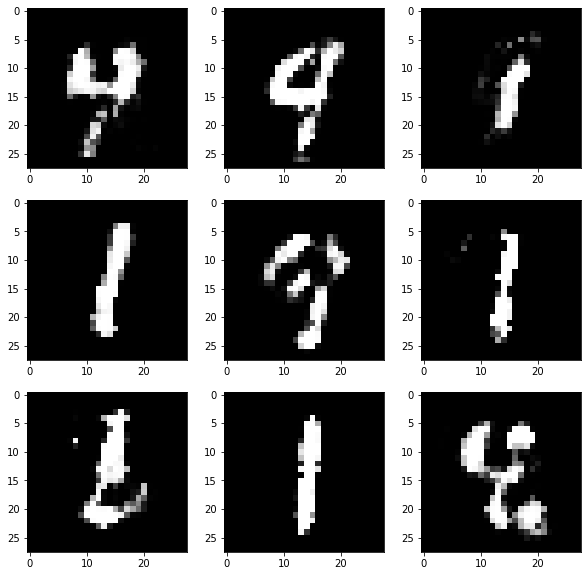

Epoch 49-->Generator Loss: 2.7683134973049164 Discriminator Loss: 0.37060864963879186


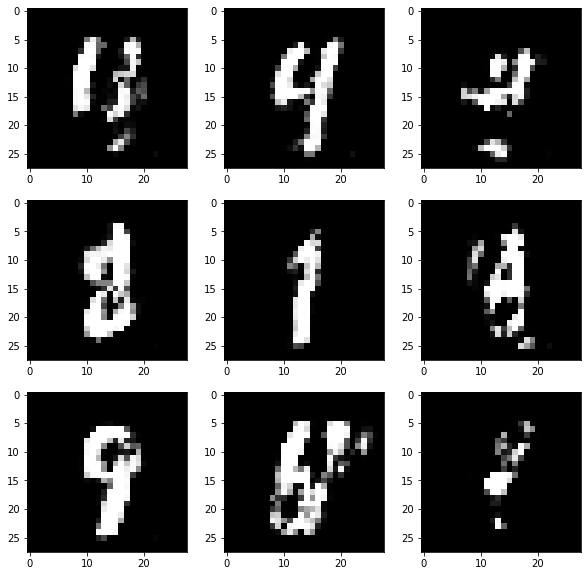

Epoch 50-->Generator Loss: 2.757721751431624 Discriminator Loss: 0.3619773781051238


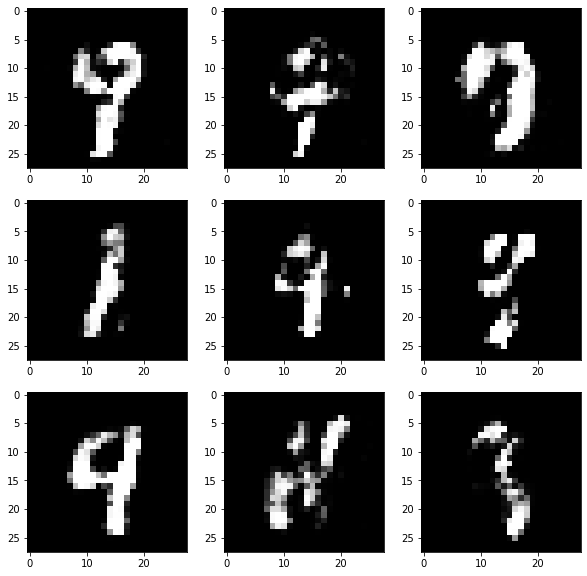

Epoch 51-->Generator Loss: 2.7617811024188996 Discriminator Loss: 0.3557901206240058


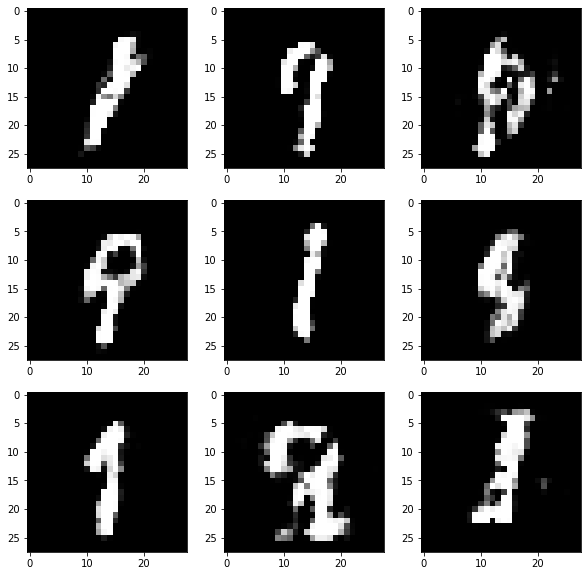

In [12]:
train(40)